In [1]:
import numpy as np 
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm, t
import matplotlib.pyplot as plt
     

In [2]:
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [3]:
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

In [4]:
nse_tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS']

In [5]:
stockList = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS']
enddate = dt.datetime.now()
startdate = enddate - dt.timedelta(days=800)

In [6]:
returns, meanReturns, covMatrix = getData(stockList, start=startdate, end=enddate)

[*********************100%%**********************]  5 of 5 completed


In [7]:
returns = returns.dropna()

In [8]:
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

In [9]:
returns['portfolio'] = returns.dot(weights)

In [10]:
covMatrix

Ticker,HDFCBANK.NS,HINDUNILVR.NS,INFY.NS,RELIANCE.NS,TCS.NS
Ticker,,,,,
HDFCBANK.NS,0.000158,0.000018,0.000046,0.000057,0.000029
HINDUNILVR.NS,0.000018,0.000132,0.000033,0.000022,0.000025
INFY.NS,0.000046,0.000033,0.000214,0.000047,0.000127
RELIANCE.NS,0.000057,0.000022,0.000047,0.000163,0.000037
TCS.NS,0.000029,0.000025,0.000127,0.000037,0.000149


In [11]:
def historicalVAR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVAR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVAR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVAR = returns <= historicalVAR(returns, alpha=5)
        return returns[belowVAR].mean()

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVAR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [17]:
Time = 100

hVaR = -historicalVAR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVAR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)


In [18]:
InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       331.42
Value at Risk 95th CI    :       1135.51
Conditional VaR 95th CI  :       1694.55


In [19]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
     

Normal VaR 95th CI       :       986.4
Normal CVaR 95th CI      :       1321.18
t-dist VaR 95th CI       :       939.73
t-dist CVaR 95th CI      :       1396.05


In [20]:
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
     

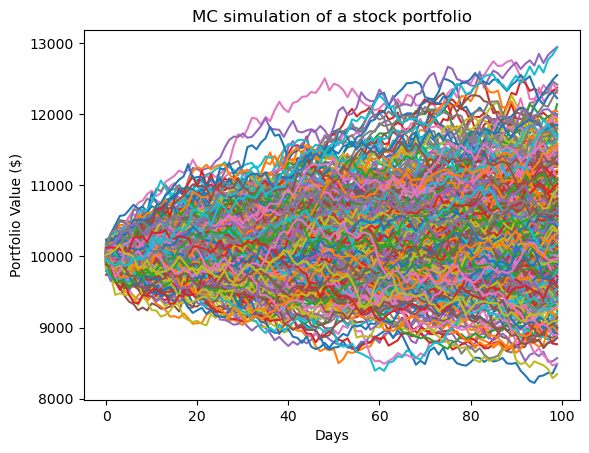

In [21]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()
     

In [22]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [23]:

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $905.57
CVaR $1154.16
